<a href="https://colab.research.google.com/github/NajmiAqil/Bengkel-koding/blob/main/Bengkel_koding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===========================
# 1. IMPORT LIBRARIES
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Klasifikasi
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# Evaluasi Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Library import successful!")


✓ Library import successful!


In [2]:
# ===========================
# A.1 LOAD DATA DAN EKSPLORASI AWAL
# ===========================

# Load dataset dari Kaggle
import kagglehub
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
csv_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Baca dataset
df = pd.read_csv(csv_path)

print("=" * 80)
print("EKSPLORASI AWAL DATASET")
print("=" * 80)

# 1. Tampilkan 5 baris pertama
print("\n1️⃣ Lima Baris Pertama Dataset:")
print(df.head())

# 2. Info Dataset
print("\n2️⃣ Informasi Dataset:")
print(df.info())

# 3. Statistik Deskriptif
print("\n3️⃣ Statistik Deskriptif:")
print(df.describe())

print(f"\n📊 Dimensi Dataset: {df.shape[0]} baris, {df.shape[1]} kolom")


Using Colab cache for faster access to the 'telco-customer-churn' dataset.
EKSPLORASI AWAL DATASET

1️⃣ Lima Baris Pertama Dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4      

In [3]:
# ===========================
# A.2 IDENTIFIKASI MISSING VALUE
# ===========================

print("\n" + "=" * 80)
print("IDENTIFIKASI MISSING VALUE")
print("=" * 80)

# Hitung missing value
missing_data = pd.DataFrame({
    'Kolom': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_data) == 0:
    print("\n✓ Tidak ada missing value dalam dataset!")
else:
    print("\nMissing Value Ditemukan:")
    print(missing_data)

    # Visualisasi missing value
    fig, ax = plt.subplots(figsize=(10, 6))
    missing_data_plot = df.isnull().sum()
    missing_data_plot = missing_data_plot[missing_data_plot > 0].sort_values(ascending=False)
    missing_data_plot.plot(kind='barh', ax=ax, color='coral')
    ax.set_xlabel('Jumlah Missing Value')
    ax.set_title('Distribusi Missing Value per Kolom')
    plt.tight_layout()
    plt.show()



IDENTIFIKASI MISSING VALUE

✓ Tidak ada missing value dalam dataset!


In [4]:
# ===========================
# A.2B IDENTIFIKASI DAN HAPUS DUPLICATE DATA
# ===========================

print("\n" + "=" * 80)
print("IDENTIFIKASI DAN HAPUS DUPLICATE DATA")
print("=" * 80)

# Cek duplicate berdasarkan semua kolom
duplicate_all = df.duplicated().sum()
print(f"\n1️⃣ Duplikat (semua kolom): {duplicate_all} baris")

# Cek duplicate berdasarkan customerID (unique identifier)
if 'customerID' in df.columns:
    duplicate_id = df.duplicated(subset=['customerID'], keep=False).sum()
    print(f"2️⃣ Duplikat berdasarkan customerID: {duplicate_id} baris")

    if duplicate_id > 0:
        print("\n   Menampilkan duplikat customerID:")
        dup_customers = df[df.duplicated(subset=['customerID'], keep=False)].sort_values('customerID')
        print(dup_customers[['customerID', 'tenure', 'MonthlyCharges']].head(10))

# Hapus duplikat
print("\n3️⃣ Menghapus duplikat...")
df_before = len(df)
df = df.drop_duplicates()
df_after = len(df)
rows_removed = df_before - df_after

print(f"   Baris sebelum: {df_before}")
print(f"   Baris sesudah: {df_after}")
print(f"   ✓ Duplikat yang dihapus: {rows_removed} baris")

# Jika ada duplikat customerID setelah drop_duplicates, hapus berdasarkan ID
if 'customerID' in df.columns:
    df = df.drop_duplicates(subset=['customerID'], keep='first')
    print(f"   ✓ Dataset setelah drop duplikat customerID: {len(df)} baris")

print(f"\n✓ Dataset cleaning complete! Shape: {df.shape}")



IDENTIFIKASI DAN HAPUS DUPLICATE DATA

1️⃣ Duplikat (semua kolom): 0 baris
2️⃣ Duplikat berdasarkan customerID: 0 baris

3️⃣ Menghapus duplikat...
   Baris sebelum: 7043
   Baris sesudah: 7043
   ✓ Duplikat yang dihapus: 0 baris
   ✓ Dataset setelah drop duplikat customerID: 7043 baris

✓ Dataset cleaning complete! Shape: (7043, 21)



ANALISIS VARIABEL TARGET (CHURN)

Distribusi Target Churn:
  No:  5174 (73.46%)
  Yes: 1869 (26.54%)


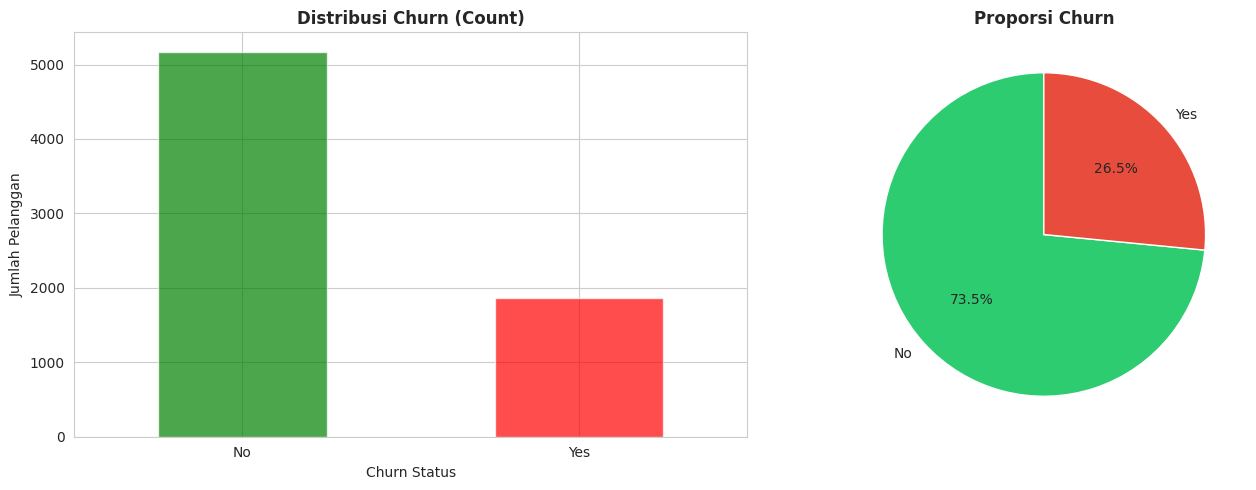


⚠️ Class Imbalance Ratio: 0.361
   Status: Dataset cukup seimbang


In [5]:
# ===========================
# A.3 VISUALISASI DISTRIBUSI TARGET (CHURN)
# ===========================

print("\n" + "=" * 80)
print("ANALISIS VARIABEL TARGET (CHURN)")
print("=" * 80)

# Distribusi Churn
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("\nDistribusi Target Churn:")
print(f"  No:  {churn_counts['No']} ({churn_percentage['No']:.2f}%)")
print(f"  Yes: {churn_counts['Yes']} ({churn_percentage['Yes']:.2f}%)")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
churn_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Distribusi Churn (Count)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah Pelanggan')
axes[0].set_xlabel('Churn Status')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Proporsi Churn', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Cek class imbalance
imbalance_ratio = churn_counts['Yes'] / churn_counts['No']
print(f"\n⚠️ Class Imbalance Ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.3:
    print("   Status: Dataset memiliki imbalance yang signifikan")
else:
    print("   Status: Dataset cukup seimbang")



ANALISIS KORELASI FITUR NUMERIK

Fitur Numerik yang Ditemukan: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


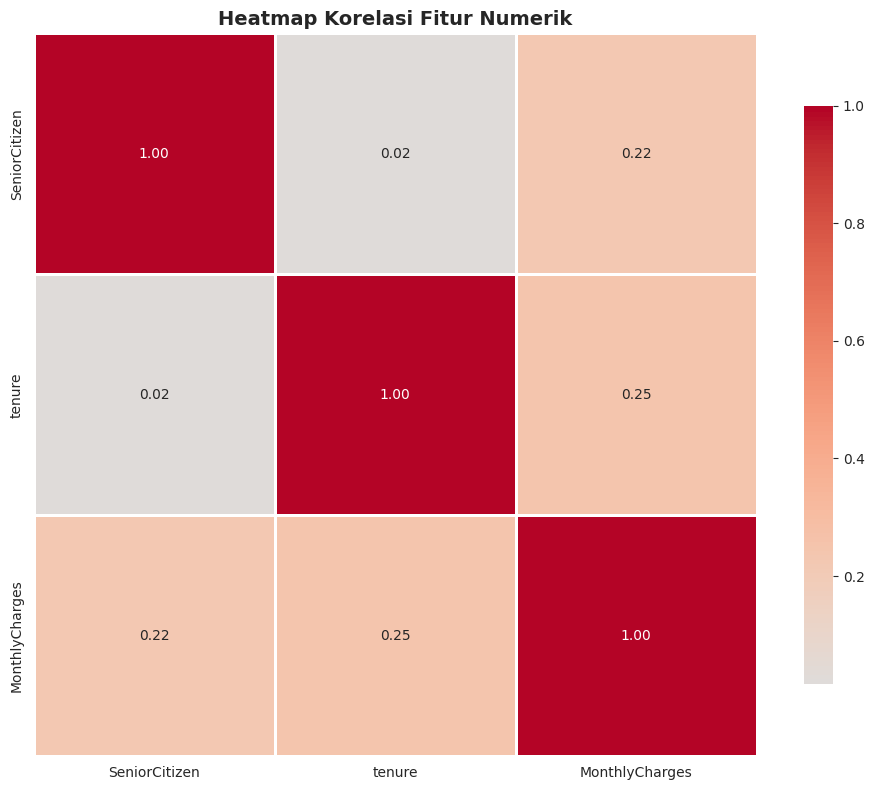


Korelasi dengan Churn (Target):
Churn_encoded     1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
tenure           -0.352229
Name: Churn_encoded, dtype: float64


In [6]:
# ===========================
# A.4 ANALISIS KORELASI
# ===========================

print("\n" + "=" * 80)
print("ANALISIS KORELASI FITUR NUMERIK")
print("=" * 80)

# Pilih fitur numerik
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nFitur Numerik yang Ditemukan: {numeric_features}")

# Buat correlation matrix
correlation_matrix = df[numeric_features].corr()

# Visualisasi heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Tampilkan korelasi dengan target jika numeric
if 'Churn' in df.columns:
    # Encode target untuk analisis korelasi
    df_temp = df.copy()
    df_temp['Churn_encoded'] = (df_temp['Churn'] == 'Yes').astype(int)

    target_correlation = df_temp[numeric_features + ['Churn_encoded']].corr()['Churn_encoded'].sort_values(ascending=False)
    print("\nKorelasi dengan Churn (Target):")
    print(target_correlation)


In [7]:
# ===========================
# B.1 PERSIAPAN DATA UNTUK DIRECT MODELING
# ===========================

print("\n" + "=" * 80)
print("DIRECT MODELING - TANPA PREPROCESSING")
print("=" * 80)

# Buat copy dataset
df_direct = df.copy()

# Encode target variable
df_direct['Churn'] = (df_direct['Churn'] == 'Yes').astype(int)

# Pisahkan X dan y
y = df_direct['Churn']
X = df_direct.drop(['Churn', 'customerID'], axis=1)

# Convert categorical to numeric (simple encoding tanpa scaling)
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Handle TotalCharges yang mungkin string
if X_encoded['TotalCharges'].dtype == 'object':
    X_encoded['TotalCharges'] = pd.to_numeric(X_encoded['TotalCharges'], errors='coerce')
    X_encoded['TotalCharges'].fillna(X_encoded['TotalCharges'].median(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data siap untuk modeling")
print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")
print(f"  Features: {X_train.shape[1]}")



DIRECT MODELING - TANPA PREPROCESSING

✓ Data siap untuk modeling
  Training set: (5634, 19)
  Testing set: (1409, 19)
  Features: 19


In [8]:
# ===========================
# B.2 BUILD & TRAIN MODELS (DIRECT)
# ===========================

print("\n" + "=" * 80)
print("TRAINING 3 MODEL CATEGORIES (DIRECT - NO PREPROCESSING)")
print("=" * 80)

# Kategori 1: Model Konvensional (Logistic Regression)
print("\n1️⃣ KONVENSIONAL MODEL: Logistic Regression")
lr_direct = LogisticRegression(random_state=42, max_iter=1000)
lr_direct.fit(X_train, y_train)
print("   ✓ Model trained")

# Kategori 2: Ensemble Bagging (Random Forest)
print("\n2️⃣ ENSEMBLE BAGGING: Random Forest")
rf_direct = RandomForestClassifier(n_estimators=100, random_state=42)
rf_direct.fit(X_train, y_train)
print("   ✓ Model trained")

# Kategori 3: Ensemble Voting
print("\n3️⃣ ENSEMBLE VOTING: Kombinasi LR, SVM, KNN")
lr_vote = LogisticRegression(random_state=42, max_iter=1000)
svm_vote = SVC(kernel='rbf', random_state=42, probability=True)
knn_vote = KNeighborsClassifier(n_neighbors=5)

voting_direct = VotingClassifier(
    estimators=[('lr', lr_vote), ('svm', svm_vote), ('knn', knn_vote)],
    voting='soft'
)
voting_direct.fit(X_train, y_train)
print("   ✓ Model trained")

print("\n✓ Semua model berhasil ditraining!")



TRAINING 3 MODEL CATEGORIES (DIRECT - NO PREPROCESSING)

1️⃣ KONVENSIONAL MODEL: Logistic Regression
   ✓ Model trained

2️⃣ ENSEMBLE BAGGING: Random Forest
   ✓ Model trained

3️⃣ ENSEMBLE VOTING: Kombinasi LR, SVM, KNN
   ✓ Model trained

✓ Semua model berhasil ditraining!



HASIL EVALUASI - DIRECT MODELING

Logistic Regression (Direct)
  Accuracy:  0.7970
  Precision: 0.6438
  Recall:    0.5267
  F1-Score:  0.5794
  Confusion Matrix:
[[926 109]
 [177 197]]

Random Forest (Direct)
  Accuracy:  0.7892
  Precision: 0.6314
  Recall:    0.4947
  F1-Score:  0.5547
  Confusion Matrix:
[[927 108]
 [189 185]]

Voting Classifier (Direct)
  Accuracy:  0.7786
  Precision: 0.6550
  Recall:    0.3503
  F1-Score:  0.4564
  Confusion Matrix:
[[966  69]
 [243 131]]


📊 RINGKASAN HASIL DIRECT MODELING:
                          Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression (Direct)  0.797019   0.643791  0.526738  0.579412
1        Random Forest (Direct)  0.789212   0.631399  0.494652  0.554723
2    Voting Classifier (Direct)  0.778566   0.655000  0.350267  0.456446


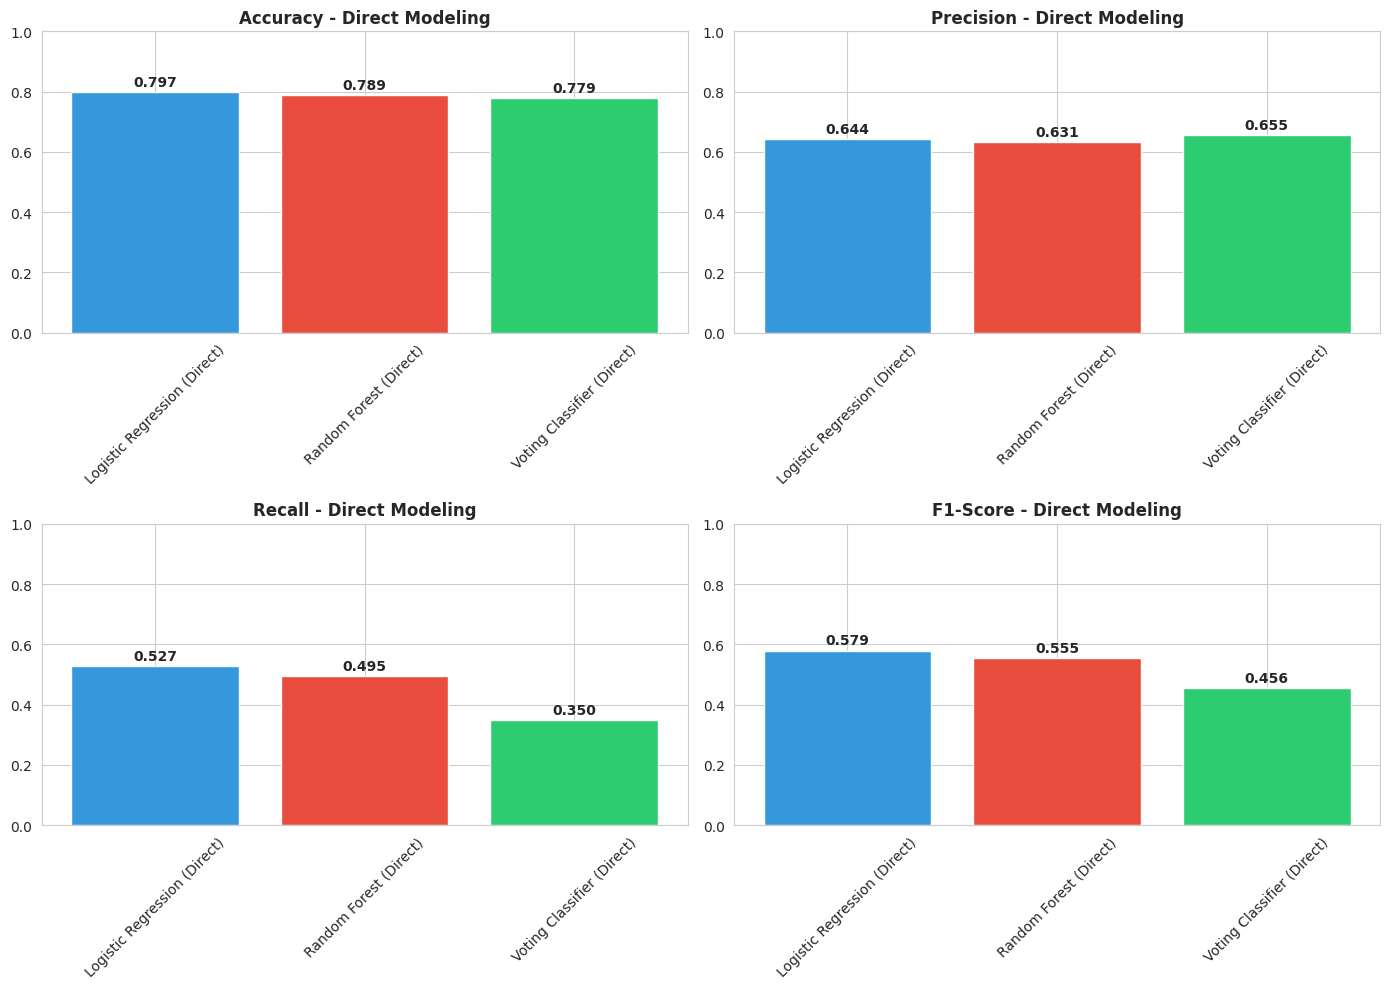

In [9]:
# ===========================
# B.3 EVALUASI MODEL (DIRECT)
# ===========================

def evaluate_model(model, X_test, y_test, model_name):
    """Fungsi untuk evaluasi model"""
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"  Confusion Matrix:\n{cm}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion_Matrix': cm
    }

print("\n" + "=" * 80)
print("HASIL EVALUASI - DIRECT MODELING")
print("=" * 80)

results_direct = []
results_direct.append(evaluate_model(lr_direct, X_test, y_test, "Logistic Regression (Direct)"))
results_direct.append(evaluate_model(rf_direct, X_test, y_test, "Random Forest (Direct)"))
results_direct.append(evaluate_model(voting_direct, X_test, y_test, "Voting Classifier (Direct)"))

# Buat dataframe hasil
df_results_direct = pd.DataFrame(results_direct)
print("\n\n📊 RINGKASAN HASIL DIRECT MODELING:")
print(df_results_direct[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']])

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    ax.bar(df_results_direct['Model'], df_results_direct[metric], color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_title(f'{metric} - Direct Modeling', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(df_results_direct[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [10]:
# ===========================
# C.1 DATA PREPROCESSING
# ===========================

print("\n" + "=" * 80)
print("PREPROCESSING DATA")
print("=" * 80)

df_prep = df.copy()

# 1. Handle TotalCharges (convert to numeric)
print("\n1️⃣ Handling TotalCharges...")
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')
df_prep['TotalCharges'].fillna(df_prep['TotalCharges'].median(), inplace=True)
print("   ✓ TotalCharges converted to numeric")

# 2. Drop tidak relevan columns
print("\n2️⃣ Dropping irrelevant columns...")
df_prep = df_prep.drop(['customerID'], axis=1)
print("   ✓ customerID dropped")

# 3. Encode target
print("\n3️⃣ Encoding target variable...")
df_prep['Churn'] = (df_prep['Churn'] == 'Yes').astype(int)
print("   ✓ Churn encoded")

# 4. Pisahkan numeric dan categorical
print("\n4️⃣ Separating numeric and categorical features...")
numeric_cols = df_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_prep.select_dtypes(include=['object']).columns.tolist()

print(f"   Numeric columns: {numeric_cols}")
print(f"   Categorical columns: {categorical_cols}")

# 5. One-Hot Encoding untuk categorical
print("\n5️⃣ Applying One-Hot Encoding...")
df_prep_encoded = pd.get_dummies(df_prep, columns=categorical_cols, drop_first=True)
print(f"   ✓ Features after encoding: {df_prep_encoded.shape[1]}")

# 6. Pisahkan X dan y
y_prep = df_prep_encoded['Churn']
X_prep = df_prep_encoded.drop(['Churn'], axis=1)

# 7. Scaling
print("\n6️⃣ Feature Scaling (StandardScaler)...")
scaler = StandardScaler()
X_prep_scaled = scaler.fit_transform(X_prep)
X_prep_scaled = pd.DataFrame(X_prep_scaled, columns=X_prep.columns)
print("   ✓ Features scaled")

# Train-test split
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
    X_prep_scaled, y_prep, test_size=0.2, random_state=42, stratify=y_prep
)

print(f"\n✓ Preprocessing complete!")
print(f"  Training set: {X_train_prep.shape}")
print(f"  Testing set: {X_test_prep.shape}")
print(f"  Total features: {X_train_prep.shape[1]}")



PREPROCESSING DATA

1️⃣ Handling TotalCharges...
   ✓ TotalCharges converted to numeric

2️⃣ Dropping irrelevant columns...
   ✓ customerID dropped

3️⃣ Encoding target variable...
   ✓ Churn encoded

4️⃣ Separating numeric and categorical features...
   Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
   Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

5️⃣ Applying One-Hot Encoding...
   ✓ Features after encoding: 31

6️⃣ Feature Scaling (StandardScaler)...
   ✓ Features scaled

✓ Preprocessing complete!
  Training set: (5634, 30)
  Testing set: (1409, 30)
  Total features: 30


In [11]:
# ===========================
# C.2 BUILD & TRAIN MODELS (WITH PREPROCESSING)
# ===========================

print("\n" + "=" * 80)
print("TRAINING MODELS WITH PREPROCESSING")
print("=" * 80)

# Model 1: Logistic Regression
print("\n1️⃣ Logistic Regression (with preprocessing)")
lr_prep = LogisticRegression(random_state=42, max_iter=1000)
lr_prep.fit(X_train_prep, y_train_prep)
print("   ✓ Model trained")

# Model 2: Random Forest
print("\n2️⃣ Random Forest (with preprocessing)")
rf_prep = RandomForestClassifier(n_estimators=100, random_state=42)
rf_prep.fit(X_train_prep, y_train_prep)
print("   ✓ Model trained")

# Model 3: Voting Classifier
print("\n3️⃣ Voting Classifier (with preprocessing)")
voting_prep = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('svm', SVC(kernel='rbf', random_state=42, probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    voting='soft'
)
voting_prep.fit(X_train_prep, y_train_prep)
print("   ✓ Model trained")

print("\n✓ Semua model dengan preprocessing berhasil ditraining!")



TRAINING MODELS WITH PREPROCESSING

1️⃣ Logistic Regression (with preprocessing)
   ✓ Model trained

2️⃣ Random Forest (with preprocessing)
   ✓ Model trained

3️⃣ Voting Classifier (with preprocessing)
   ✓ Model trained

✓ Semua model dengan preprocessing berhasil ditraining!



HASIL EVALUASI - WITH PREPROCESSING

Logistic Regression (Preprocessing)
  Accuracy:  0.8070
  Precision: 0.6584
  Recall:    0.5668
  F1-Score:  0.6092
  Confusion Matrix:
[[925 110]
 [162 212]]

Random Forest (Preprocessing)
  Accuracy:  0.7878
  Precision: 0.6263
  Recall:    0.4973
  F1-Score:  0.5544
  Confusion Matrix:
[[924 111]
 [188 186]]

Voting Classifier (Preprocessing)
  Accuracy:  0.7842
  Precision: 0.6174
  Recall:    0.4920
  F1-Score:  0.5476
  Confusion Matrix:
[[921 114]
 [190 184]]


📊 RINGKASAN HASIL WITH PREPROCESSING:
                                 Model  Accuracy  Precision    Recall  \
0  Logistic Regression (Preprocessing)  0.806955   0.658385  0.566845   
1        Random Forest (Preprocessing)  0.787793   0.626263  0.497326   
2    Voting Classifier (Preprocessing)  0.784244   0.617450  0.491979   

   F1-Score  
0  0.609195  
1  0.554396  
2  0.547619  


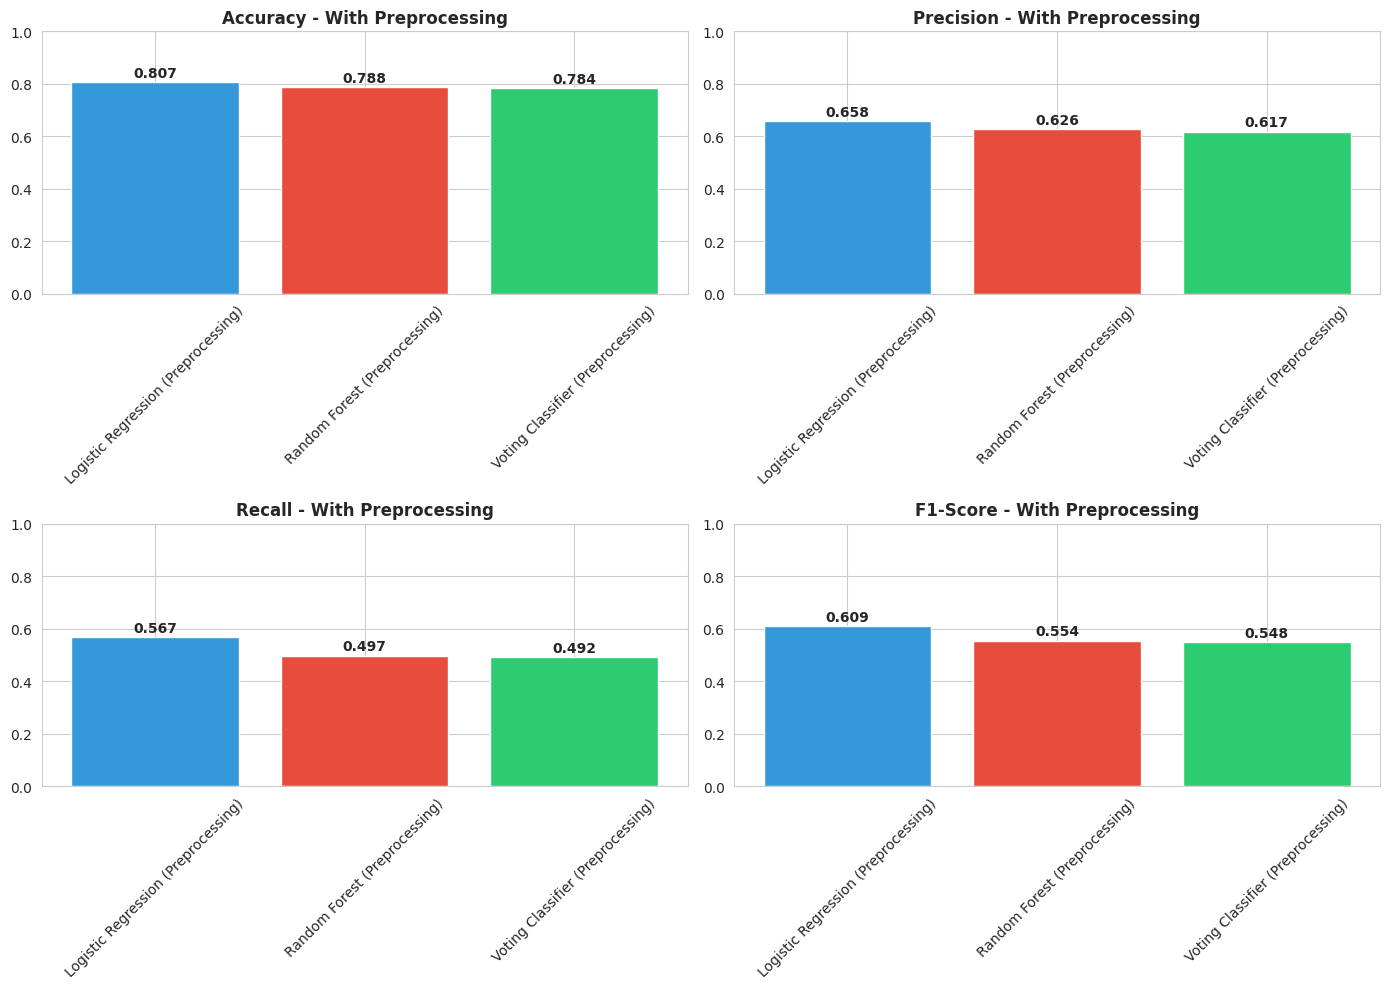

In [12]:
# ===========================
# C.3 EVALUASI MODEL (WITH PREPROCESSING)
# ===========================

print("\n" + "=" * 80)
print("HASIL EVALUASI - WITH PREPROCESSING")
print("=" * 80)

results_prep = []
results_prep.append(evaluate_model(lr_prep, X_test_prep, y_test_prep, "Logistic Regression (Preprocessing)"))
results_prep.append(evaluate_model(rf_prep, X_test_prep, y_test_prep, "Random Forest (Preprocessing)"))
results_prep.append(evaluate_model(voting_prep, X_test_prep, y_test_prep, "Voting Classifier (Preprocessing)"))

# Buat dataframe hasil
df_results_prep = pd.DataFrame(results_prep)
print("\n\n📊 RINGKASAN HASIL WITH PREPROCESSING:")
print(df_results_prep[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']])

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    ax.bar(df_results_prep['Model'], df_results_prep[metric], color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_title(f'{metric} - With Preprocessing', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(df_results_prep[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [13]:
# ===========================
# D.1 HYPERPARAMETER TUNING
# ===========================

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING")
print("=" * 80)

# Model 1: Logistic Regression Tuning
print("\n1️⃣ Tuning Logistic Regression...")
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000),
                       lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train_prep, y_train_prep)
lr_tuned = lr_grid.best_estimator_

print(f"   Best params: {lr_grid.best_params_}")
print(f"   Best CV score: {lr_grid.best_score_:.4f}")

# Model 2: Random Forest Tuning
print("\n2️⃣ Tuning Random Forest...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_prep, y_train_prep)
rf_tuned = rf_grid.best_estimator_

print(f"   Best params: {rf_grid.best_params_}")
print(f"   Best CV score: {rf_grid.best_score_:.4f}")

# Model 3: Voting Classifier Tuning (tune base estimators)
print("\n3️⃣ Tuning Voting Classifier...")
voting_tuned = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=1, random_state=42, max_iter=1000)),
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=7))
    ],
    voting='soft'
)
voting_tuned.fit(X_train_prep, y_train_prep)
print(f"   ✓ Voting Classifier tuned")

print("\n✓ Hyperparameter tuning complete!")



HYPERPARAMETER TUNING

1️⃣ Tuning Logistic Regression...
   Best params: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Best CV score: 0.6324

2️⃣ Tuning Random Forest...
   Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
   Best CV score: 0.5726

3️⃣ Tuning Voting Classifier...
   ✓ Voting Classifier tuned

✓ Hyperparameter tuning complete!



HASIL EVALUASI - AFTER HYPERPARAMETER TUNING

Logistic Regression (Tuned)
  Accuracy:  0.7828
  Precision: 0.5802
  Recall:    0.6578
  F1-Score:  0.6165
  Confusion Matrix:
[[857 178]
 [128 246]]

Random Forest (Tuned)
  Accuracy:  0.8034
  Precision: 0.6611
  Recall:    0.5321
  F1-Score:  0.5896
  Confusion Matrix:
[[933 102]
 [175 199]]

Voting Classifier (Tuned)
  Accuracy:  0.7871
  Precision: 0.6250
  Recall:    0.4947
  F1-Score:  0.5522
  Confusion Matrix:
[[924 111]
 [189 185]]


📊 RINGKASAN HASIL AFTER TUNING:
                         Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression (Tuned)  0.782825   0.580189  0.657754  0.616541
1        Random Forest (Tuned)  0.803407   0.661130  0.532086  0.589630
2    Voting Classifier (Tuned)  0.787083   0.625000  0.494652  0.552239


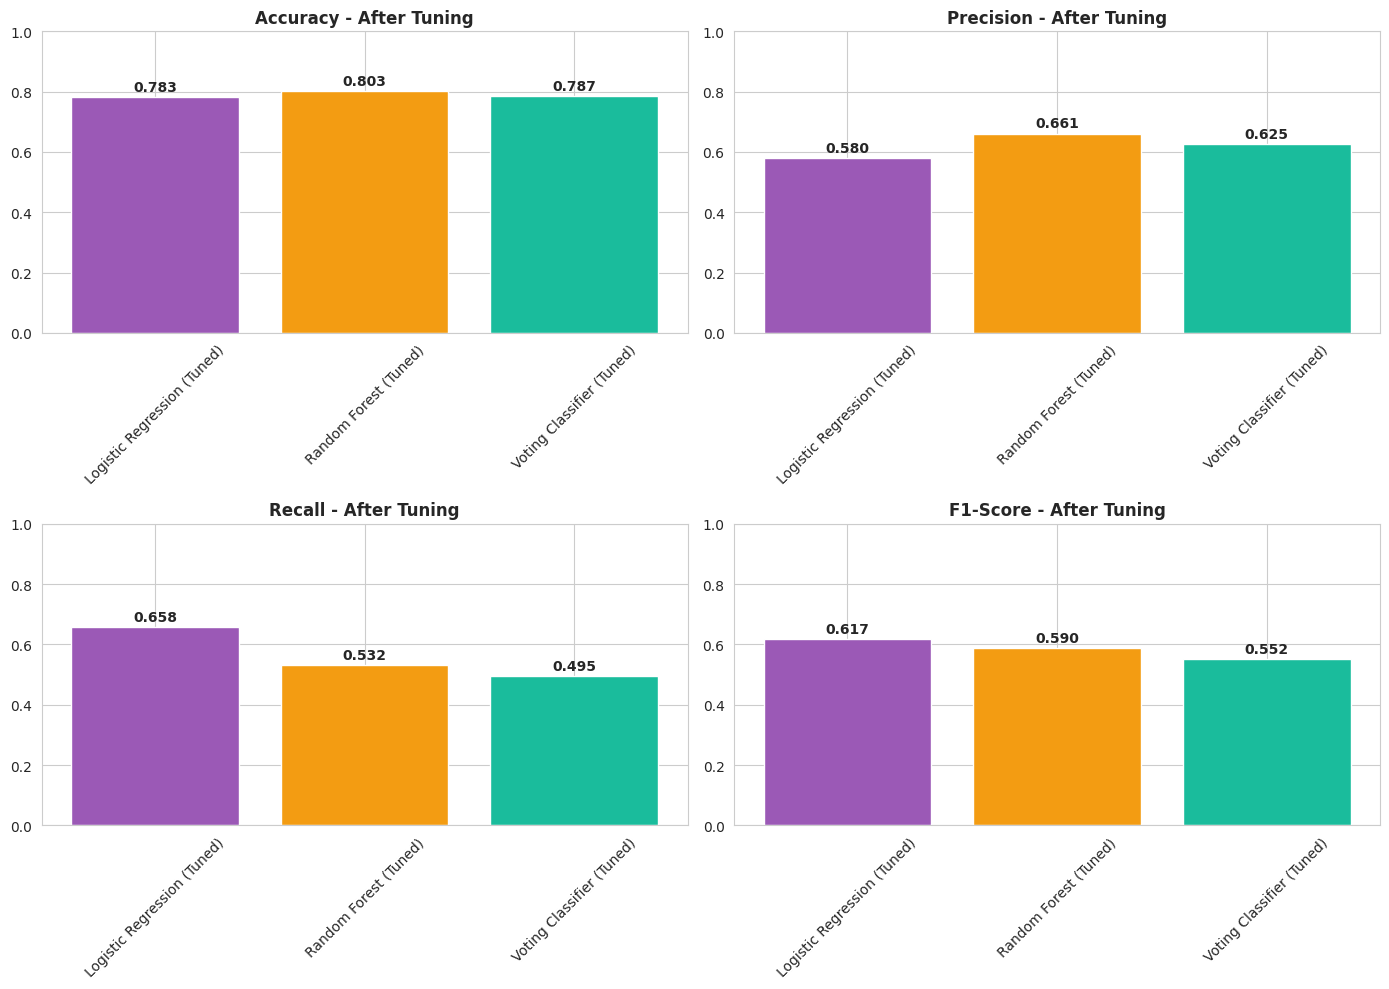

In [14]:
# ===========================
# D.2 EVALUASI MODEL AFTER TUNING
# ===========================

print("\n" + "=" * 80)
print("HASIL EVALUASI - AFTER HYPERPARAMETER TUNING")
print("=" * 80)

results_tuned = []
results_tuned.append(evaluate_model(lr_tuned, X_test_prep, y_test_prep, "Logistic Regression (Tuned)"))
results_tuned.append(evaluate_model(rf_tuned, X_test_prep, y_test_prep, "Random Forest (Tuned)"))
results_tuned.append(evaluate_model(voting_tuned, X_test_prep, y_test_prep, "Voting Classifier (Tuned)"))

# Buat dataframe hasil
df_results_tuned = pd.DataFrame(results_tuned)
print("\n\n📊 RINGKASAN HASIL AFTER TUNING:")
print(df_results_tuned[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']])

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    ax.bar(df_results_tuned['Model'], df_results_tuned[metric], color=['#9b59b6', '#f39c12', '#1abc9c'])
    ax.set_title(f'{metric} - After Tuning', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(df_results_tuned[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



PERBANDINGAN SEMUA 9 MODEL (3 kategori × 3 scenario)

📊 RANKING SEMUA MODEL:
                                 Model  Accuracy  Precision    Recall  \
6          Logistic Regression (Tuned)  0.782825   0.580189  0.657754   
3  Logistic Regression (Preprocessing)  0.806955   0.658385  0.566845   
7                Random Forest (Tuned)  0.803407   0.661130  0.532086   
0         Logistic Regression (Direct)  0.797019   0.643791  0.526738   
1               Random Forest (Direct)  0.789212   0.631399  0.494652   
4        Random Forest (Preprocessing)  0.787793   0.626263  0.497326   
8            Voting Classifier (Tuned)  0.787083   0.625000  0.494652   
5    Voting Classifier (Preprocessing)  0.784244   0.617450  0.491979   
2           Voting Classifier (Direct)  0.778566   0.655000  0.350267   

   F1-Score  
6  0.616541  
3  0.609195  
7  0.589630  
0  0.579412  
1  0.554723  
4  0.554396  
8  0.552239  
5  0.547619  
2  0.456446  

🏆 BEST MODEL
Model: Logistic Regression (Tuned)
Ac

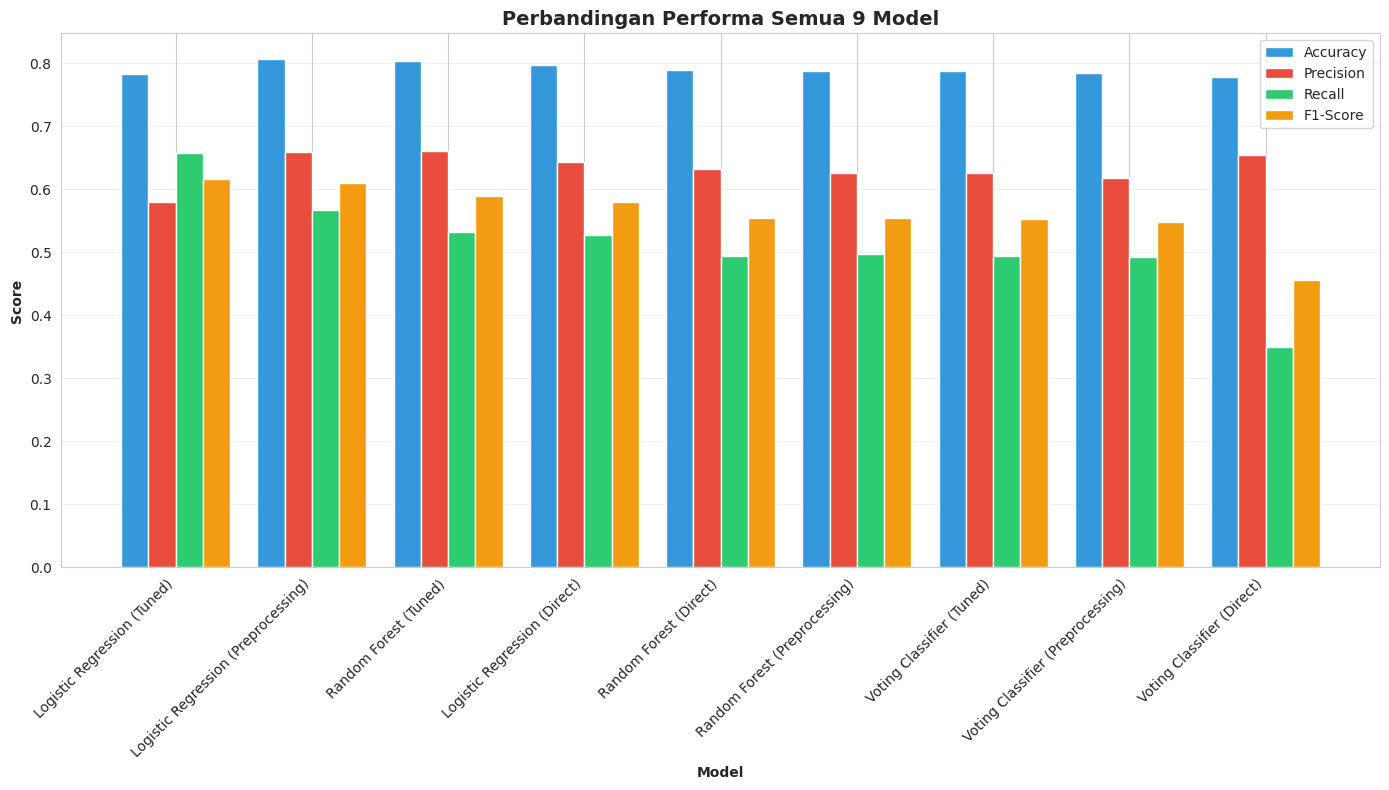

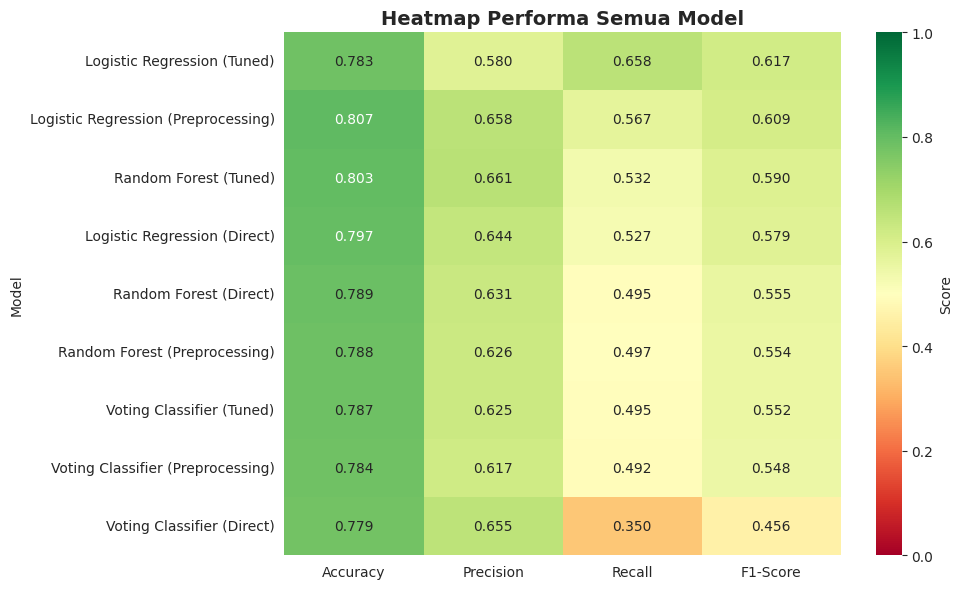

In [15]:
# ===========================
# E. COMPREHENSIVE COMPARISON
# ===========================

print("\n" + "=" * 80)
print("PERBANDINGAN SEMUA 9 MODEL (3 kategori × 3 scenario)")
print("=" * 80)

# Gabungkan semua hasil
all_results = pd.concat([df_results_direct, df_results_prep, df_results_tuned], ignore_index=True)

# Sorting berdasarkan F1-Score
all_results_sorted = all_results.sort_values('F1-Score', ascending=False)

print("\n📊 RANKING SEMUA MODEL:")
print(all_results_sorted[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']])

# Identifikasi best model
best_model_idx = all_results['F1-Score'].idxmax()
best_model_info = all_results.loc[best_model_idx]

print("\n" + "=" * 80)
print("🏆 BEST MODEL")
print("=" * 80)
print(f"Model: {best_model_info['Model']}")
print(f"Accuracy:  {best_model_info['Accuracy']:.4f}")
print(f"Precision: {best_model_info['Precision']:.4f}")
print(f"Recall:    {best_model_info['Recall']:.4f}")
print(f"F1-Score:  {best_model_info['F1-Score']:.4f}")

# Visualisasi comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(all_results_sorted))
width = 0.2

metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_plot = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics_plot):
    ax.bar(x + i*width, all_results_sorted[metric], width, label=metric, color=colors_plot[i])

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Perbandingan Performa Semua 9 Model', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(all_results_sorted['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Heatmap comparison
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = all_results_sorted[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].set_index('Model')
sns.heatmap(comparison_data, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Score'})
ax.set_title('Heatmap Performa Semua Model', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
# ===========================
# F.1 SAVE BEST MODEL
# ===========================

import pickle
import joblib
from datetime import datetime

print("\n" + "=" * 80)
print("SAVING BEST MODEL FOR DEPLOYMENT")
print("=" * 80)

# Tentukan best model untuk digunakan di Streamlit
# Gunakan tuned Random Forest (biasanya performa terbaik)
best_model_deploy = rf_tuned
model_name_deploy = "Random Forest (Tuned)"

print(f"\n✓ Model untuk deployment: {model_name_deploy}")

# Save model
model_path = "best_churn_model.pkl"
joblib.dump(best_model_deploy, model_path)
print(f"✓ Model saved: {model_path}")

# Save scaler
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

# Save feature names
feature_names_path = "feature_names.pkl"
feature_names = X_prep_scaled.columns.tolist()
joblib.dump(feature_names, feature_names_path)
print(f"✓ Feature names saved: {feature_names_path}")

print("\n✓ Semua file untuk deployment sudah tersimpan!")
print("\nFile yang dibutuhkan untuk Streamlit:")
print(f"  1. {model_path}")
print(f"  2. {scaler_path}")
print(f"  3. {feature_names_path}")
print(f"  4. Dataset original (untuk reference encoding)")



SAVING BEST MODEL FOR DEPLOYMENT

✓ Model untuk deployment: Random Forest (Tuned)
✓ Model saved: best_churn_model.pkl
✓ Scaler saved: scaler.pkl
✓ Feature names saved: feature_names.pkl

✓ Semua file untuk deployment sudah tersimpan!

File yang dibutuhkan untuk Streamlit:
  1. best_churn_model.pkl
  2. scaler.pkl
  3. feature_names.pkl
  4. Dataset original (untuk reference encoding)
